In [196]:
using PyPlot, StatsBase, Printf, DelimitedFiles
using Revise
using MDToolbox
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

In [197]:
# setup constants
KBT = KB_kcalpermol*300.0
spring_constant = 200.0 * (pi/180.0)^2; # conversion of the unit from kcal/mol/rad^2 to kcal/

In [198]:
# umbrella window centers
umbrella_center = Float64.(collect(0:3:180))
K = length(umbrella_center)

61

In [199]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/umbrella_alat/3_prod/run_%d.dat" umbrella_center[k]
  x = readdlm(filename);
  push!(data_k, x[:, 2:2])
end

In [201]:
delta_pmf = sp_delta_pmf(umbrella_center, data_k, KBT, spring_constant);
delta_pmf_vector = delta_pmf[:] .- mean(delta_pmf);

In [259]:
weight = []
residual = []

sigma_rdf = 3.0:1.0:13.0
for s in sigma_rdf
    M = sp_design_matrix(umbrella_center, data_k, s);
    M_standardized, mean_M, std_M = sp_standardize(M);
    w, r = sp_lsquares(delta_pmf_vector, M_standardized);
    push!(weight, w)
    push!(residual, r)
end

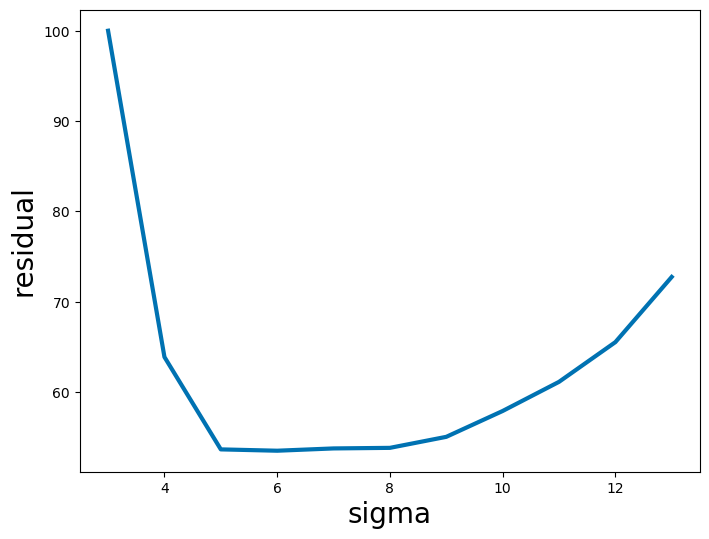

PyObject Text(38.0, 0.5, 'residual')

In [260]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(sigma_rdf, residual, linewidth=3)
xlabel("sigma",fontsize=20)
ylabel("residual",fontsize=20)

In [261]:
weight_optimal = weight[argmin(residual)]
sigma_rdf_optimal = sigma_rdf[argmin(residual)]
weight = nothing
residual = nothing

In [262]:
#sigma_rdf = abs(umbrella_center[2] - umbrella_center[1])
sigma_rdf = sigma_rdf_optimal
@time M = sp_design_matrix(umbrella_center, data_k, sigma_rdf);
M_standardized, mean_M, std_M = sp_standardize(M);

  0.041807 seconds (237.11 k allocations: 18.210 MiB)


In [263]:
lambda = 0.0001;
@time weight, residual = sp_descent(delta_pmf_vector, M_standardized, lambda, condition=1e-10, iter_max=100000);

[ Cycle Count = 100001 ]
[ Complete Condition ]
  Max Differ = 1.2678932466703152e-6


  2.048710 seconds (12.30 M allocations: 6.598 GiB, 32.11% gc time)


In [264]:
residual

62.20915672276769

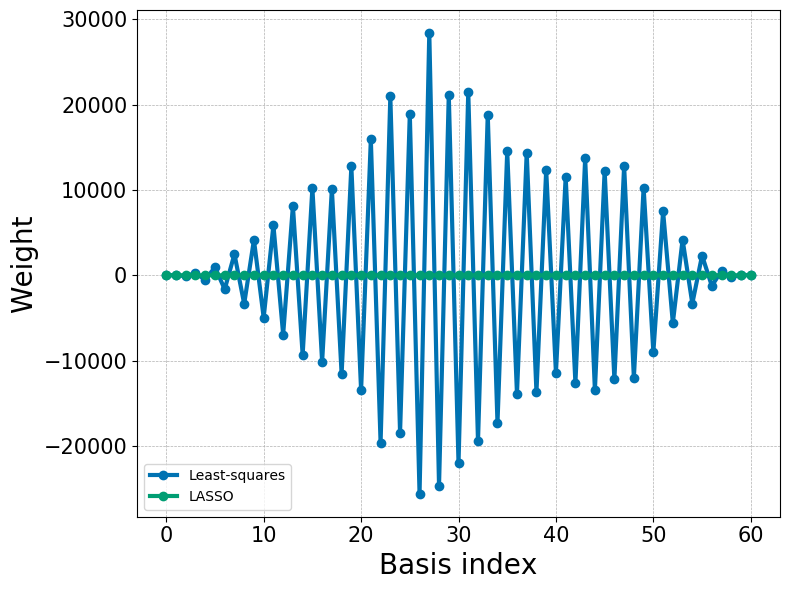

PyObject <matplotlib.legend.Legend object at 0x16375d410>

In [273]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(weight_optimal[:], linewidth=3, "-o", label="Least-squares")
ax.plot(weight[:], linewidth=3, "-o", label="LASSO")
xlabel("Basis index",fontsize=20)
ylabel("Weight",fontsize=20)

#ax.set(xlim=[-1, 60], ylim=[-0.3, 0.3])
ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

plt.legend(loc="lower left")

#savefig("lasso_along_path_weight.png", dpi=350)

In [266]:
pmf = sp_cumulate_pmf(umbrella_center, weight, umbrella_center, sigma_rdf, mean_M, std_M)
pmf_lsquares = sp_cumulate_pmf(umbrella_center, weight_optimal, umbrella_center, sigma_rdf, mean_M, std_M)

61-element Array{Float64,1}:
  7.143323727162952
  7.237188543766806
  7.299503480584108
  7.403364946047177
  7.5610036173862785
  7.730676220014276
  8.040354240912267
  8.34350014890025
  8.70678902008932
  9.033970735081413
  9.425248997627579
  9.810209753547598
 10.183866810160326
  ⋮
  3.2166305332643343
  2.616363879640872
  2.1998809329471882
  1.834106134058807
  1.425316871698918
  1.0587841908884332
  0.7086617061192069
  0.4869855952337012
  0.16451243694254458
  0.012268579745636998
  0.0
  0.05781228205972866

In [267]:
pmf = pmf .- pmf[1]
pmf_lsquares = pmf_lsquares .- pmf_lsquares[1]

61-element Array{Float64,1}:
  0.0
  0.0938648166038547
  0.15617975342115642
  0.2600412188842256
  0.41767989022332674
  0.5873524928513243
  0.8970305137493151
  1.2001764217372974
  1.5634652929263675
  1.890647007918461
  2.281925270464627
  2.6668860263846463
  3.0405430829973747
  ⋮
 -3.9266931938986174
 -4.52695984752208
 -4.9434427942157635
 -5.309217593104145
 -5.718006855464034
 -6.0845395362745185
 -6.434662021043745
 -6.6563381319292505
 -6.978811290220407
 -7.131055147417315
 -7.143323727162952
 -7.085511445103223

In [271]:
using JLD2
@load "wham.jld2" bin_center pmf_m
@save "lasso_wham_comparison.jld2" bin_center pmf_m umbrella_center pmf pmf_lsquares sigma_rdf_optimal weight_optimal

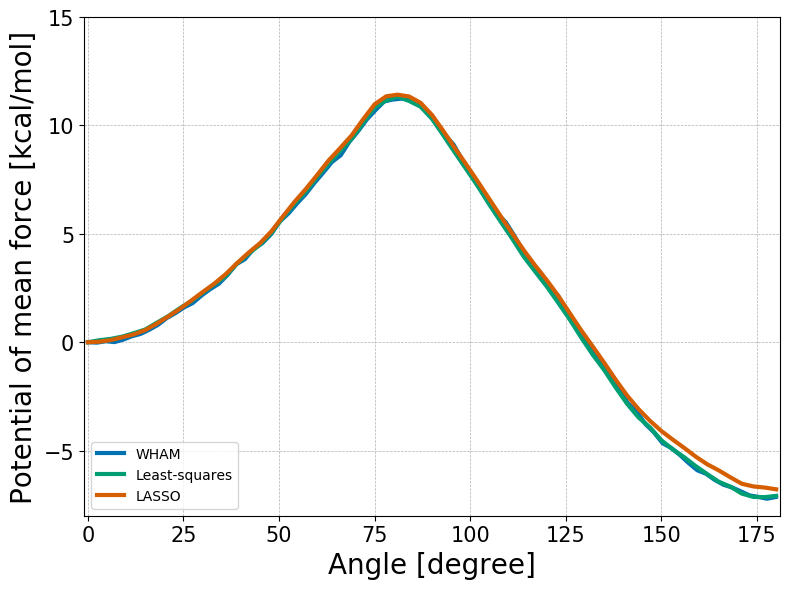

In [268]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(bin_center, pmf_m[:], linewidth=3, label="WHAM")
ax.plot(umbrella_center[:], pmf_lsquares[:], linewidth=3, label="Least-squares")
ax.plot(umbrella_center[:], pmf[:], linewidth=3, label="LASSO")
xlabel("Angle [degree]",fontsize=20)
ylabel("Potential of mean force [kcal/mol]",fontsize=20)

# detailed options (not necessary, just for reference)
ax.set(xlim=[-1, 181], ylim=[-8, 15])
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

plt.legend(loc="lower left")

savefig("lasso_wham_comparison", dpi=350)